# Install Detectron


In [2]:
# install dependencies
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

  Cloning https://github.com/facebookresearch/fvcore.git to /private/var/folders/dz/pf_09kbx7tn8vmqr45t6sb9m0000gn/T/pip-req-build-uicjroc6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /private/var/folders/dz/pf_09kbx7tn8vmqr45t6sb9m0000gn/T/pip-req-build-uicjroc6
  Resolved https://github.com/facebookresearch/fvcore.git to commit 4d14ad0a8eb3ec002c87e5d3421a0d498dccebcc
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/cocoapi.git to /private/var/folders/dz/pf_09kbx7tn8vmqr45t6sb9m0000gn/T/pip-req-build-aijkngb6
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /private/var/folders/dz/pf_09kbx7tn8vmqr45t6sb9m0000gn/T/pip-req-build-aijkngb6
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Using cached yacs-0.1.8-py3-none-any.whl.metadata (639 bytes)
  Us

'2.2.1'

In [3]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 15359, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 15359 (delta 31), reused 43 (delta 16), pack-reused 15275
Receiving objects: 100% (15359/15359), 6.23 MiB | 5.51 MiB/s, done.
Resolving deltas: 100% (11146/11146), done.
Obtaining file:///Users/sandesh/Coding%20/Python/DP%20/detectron2_repo
  Preparing metadata (setup.py) ... done
  Using cached pycocotools-2.0.7-cp311-cp311-macosx_10_9_universal2.whl.metadata (1.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Import Libraries

In [4]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import itertools
import json
import random

from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog

ModuleNotFoundError: No module named 'google.colab'

# Generic Function to get Image Data

In [ ]:
#function loads the dataset into the format required for detectron
#https://detectron2.readthedocs.io/tutorials/datasets.html
def getImageDicts(imgDir):
    #print(imgDir)
    #get json file that stores the annotations
    jsonFile = os.path.join(imgDir,"via_region_data.json")
    #store image annotations
    with open(jsonFile) as f:
        imgAnnotations = json.load(f)
    #store the image annotations in required format for detectron
    #each element is a dictionary in itself
    datasetDicts = []
    for id, value in enumerate(imgAnnotations.values()):
        #create empty record for current image
        record= {}
        #get path for current image
        filepath = os.path.join(imgDir,value['filename'])
        try:
            #the json has some filepaths that are not available in the given dataset
            #this will skip those filepaths
            height, width = cv2.imread(filepath).shape[:2]
        except AttributeError:
            continue
        record['file_name'] = filepath
        record['image_id'] = id
        record['height'] = height
        record['width'] = width

        annos = value['regions']
        objs = []
        for _, anno in annos.items():
            anno = anno['shape_attributes']
            px = anno['all_points_x']
            py = anno['all_points_y']
            #convert x and y coordinates into a list of form [x1,y1,x2,y2...]
            poly = [(x + 0.5, y + 0.5) for x,y in zip(px,py)]
            poly = list(itertools.chain.from_iterable(poly))

            obj = {
                'bbox' : [np.min(px), np.min(py), np.max(px), np.max(py)],
                'bbox_mode' : BoxMode.XYXY_ABS,
                'segmentation' : [poly],
                'category_id' : 0,
                'iscrowd' : 0
            }
            objs.append(obj)
        record['annotations'] = objs
        datasetDicts.append(record)
    print("HERE")
    return datasetDicts

In [ ]:
#register dataset to Detectron
datasetPath = "/content/drive/My Drive/Car-Damage-Dataset/"
for d in ["train","val"]:
    #DatasetCatalog.clear()
    DatasetCatalog.register("car_dataset_"+d, lambda d=d: getImageDicts(datasetPath + d))
    MetadataCatalog.get("car_dataset_"+d).thing_classes = ["damage"]

In [ ]:
print(len(imageDicts))

49


HERE


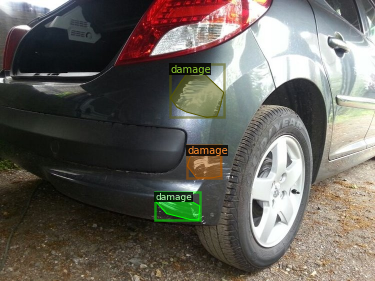

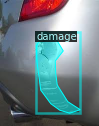

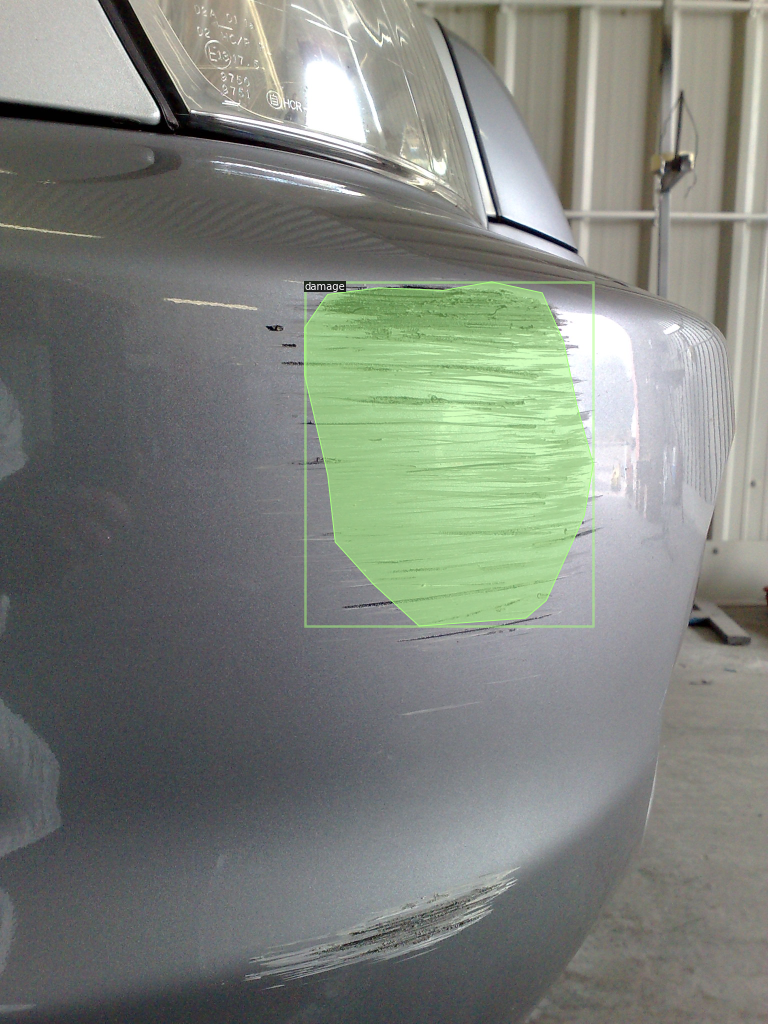

In [ ]:
imageDicts = getImageDicts(datasetPath+"train")
metadata = MetadataCatalog.get("car_dataset_train")
for item in random.sample(imageDicts, 3):
    img = cv2.imread(item['file_name'])
    visualizer = Visualizer(img[:,:,::-1], metadata=metadata,scale=0.5)
    vis = visualizer.draw_dataset_dict(item)
    cv2_imshow(vis.get_image()[:,:,::-1])

## Training

Fine-tune COCO pretrained Resnet-50 FPN Mask R-CNN

In [ ]:
#set training configuration
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("car_dataset_train", )
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.002
cfg.SOLVER.MAX_ITER = 350   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (damage)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


HERE


'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


OrderedDict()

In [ ]:
#!kill 3182
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir output

## Create Predictor

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#cfg.MODEL.WEIGHTS = "/content/drive/My Drive/Saved Models/BestModels/Maskrcnn/model_final_detectron2_44.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.DATASETS.TEST = ("car_dataset_val", )
predictor = DefaultPredictor(cfg)

## Visualize Predictions

HERE


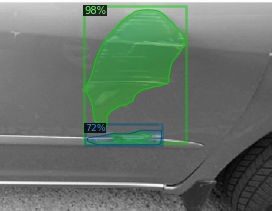

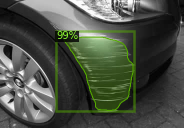

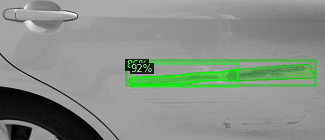

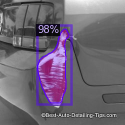

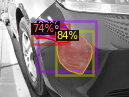

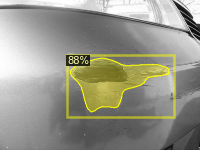

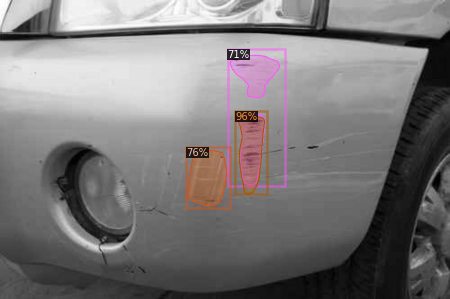

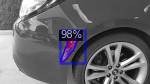

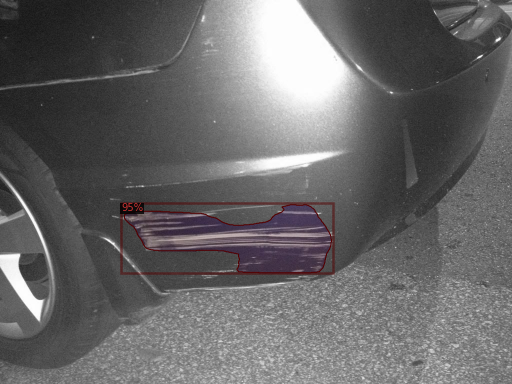

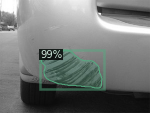

In [ ]:
from detectron2.utils.visualizer import ColorMode
valImgDicts = getImageDicts(datasetPath+"val")
for d in random.sample(valImgDicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    #print(outputs)
    v = Visualizer(im[:, :, ::-1],
                   metadata=metadata, 
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW 
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("car_dataset_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "car_dataset_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

HERE
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.849
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.334
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.337
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDe

OrderedDict([('bbox',
              {'AP': 39.44865288080198,
               'AP50': 84.94868168135496,
               'AP75': 33.42000166403196,
               'APl': 30.258063346735447,
               'APm': 52.462246224622454,
               'APs': 5.0495049504950495}),
             ('segm',
              {'AP': 23.97820772900472,
               'AP50': 73.59838731125859,
               'AP75': 10.378669445891955,
               'APl': 28.780378037803782,
               'APm': 29.21419512868041,
               'APs': 7.574257425742574})])